This notebook is used for testing the posibilities of the data augmentation in keras. The functionality will added to the 2D/3D networks once the tests are done. 

In [1]:
# general imports
import sys,os,time,random
from os import walk
import pickle

# scientific computing
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
import skimage
from skimage.io import imread, imsave
import scipy

from __future__ import print_function
# machine learning stuff
import tensorflow as tf
import keras 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [2]:
%matplotlib inline

In [3]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.6
tensorflow 1.3.0


In [4]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [5]:
# Setup for the gpu: 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0', '/gpu:1']

In [6]:
# check the output of the command above
tf.device("/gpu:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# this pone should help with the images of the large size
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [7]:
# this part is necessary to set the params from the command line
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=32, help='Number of samples (N) in train and valid')
# TODO: Is it used ? 
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
# TODO: Is it used ?
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="sq", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=1, help='This is the covariance when kern=gaus')
parser.add_argument('-scale', type=int, nargs='?',default=1, help='Scale the input image and labels')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')

args = parser.parse_args()

In [10]:
# set the passed parameters here if you forgot them
args.framesize = 256
args.scale = 1
args.nsamples = 32

print(args)

Namespace(cov=1, data='cells', framesize=256, kern='sq', lr=5e-05, nsamples=32, scale=1, seed=0, stride=1)


In [11]:
# how much to extend the initial image 
patch_size = int(32)
framesize = int(args.framesize/args.scale)
channels = int(3)
framesize_h = framesize_w = framesize
noutputs = 1

In [12]:
paramfilename = str(args.scale) + "-" + str(patch_size) + "-" + args.data + "-" + args.kern + str(args.cov) + "_params.p"
datasetfilename = str(args.scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + args.kern + str(args.stride) + "-" + args.data + "-" + str(args.cov) + "-dataset.p"
print(paramfilename)
print(datasetfilename)

1-32-cells-sq1_params.p
1-32-256-sq1-cells-1-dataset.p


In [13]:
#reproducibility
random.seed(args.seed)
np.random.seed(args.seed)
tf.set_random_seed(args.seed)

In [14]:
if (args.kern == "sq"):
    ef = ((patch_size/args.stride)**2.0)
elif (args.kern == "gaus"):
    ef = 1.0
print("ef", ef)

ef 1024.0


In [15]:
# input shape is the image shape without the pathces
input_shape = (framesize, framesize, channels)
ext_shape = (input_shape[0] + patch_size, input_shape[0] + patch_size, 1)

print (input_shape, ext_shape)

(256, 256, 3) (288, 288, 1)


In [18]:
# fucntions to see the results 
def genGausImage(framesize, mx, my, cov=1):
    x, y = np.mgrid[0:framesize, 0:framesize]
    pos = np.dstack((x, y))
    mean = [mx, my]
    cov = [[cov, 0], [0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(len(markers),k-patch_size/2,l-patch_size/2,cov)
    return gaus_img

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath)    
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print("unknown label format")
    
    binsize = [scale,scale]
    out = np.zeros(size)
    for i in range(binsize[0]):
        for j in range(binsize[1]):
            out = np.maximum(lab[i::binsize[0], j::binsize[1]], out)
        
    print(lab.sum(),out.sum())
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers, x,y,h,w):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, stride, scale):
    
    height = int ((img_pad.shape[0])/args.stride)
    width = int ((img_pad.shape[1])/args.stride)
    print("label size: ", height, width)
    labels = np.zeros((noutputs, height, width))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                count = getCellCountCells(markers, x*args.stride,y*args.stride,patch_size,patch_size)  
                for i in range(0,noutputs):
                    labels[i][y][x] = count[i]

    
    elif (args.kern == "gaus"):
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers[base_y:base_y+width,base_x:base_x+width])
    

    count_total = getCellCountCells(markers, 0,0,framesize_h+patch_size,framesize_w+patch_size)
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_x,  base_y, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    img_pad = np.pad(img[:,:,0], int ((patch_size)/2), "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:2])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    
    # labels_not_squarified = np.pad(markers,  int ((patch_size)/2), "constant", constant_values=0)
    
    markers = np.pad(markers, patch_size, "constant", constant_values=0)
    # img = np.array(markers.reshape((320, 320, 1)), dtype=np.float32).astype(np.uint8)
    # plt.imshow(markers)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, args.stride, scale)
    return img, labels, count, markers[None, patch_size:-patch_size, patch_size:-patch_size]

In [28]:
# read the files from the test folder 
import glob

# prefix = '/Users/kkolyva/'
prefix = '/home/milkyklim/'
folder = prefix + 'dl-cell-counting/algorithm/data/test-cells'
folder_images = "" # 'images/'
folder_labels = "" # 'labels/'
img_ext = '.png'

print('Images path:', folder + folder_images)
print('Labels path:', folder + folder_labels)

imgs = []

for filename in glob.iglob(folder + folder_labels + "/*dots" + img_ext):
    imgg = filename.replace(folder_labels + "dots", folder_images + "cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Images path: /home/milkyklim/dl-cell-counting/algorithm/data/test-cells
Labels path: /home/milkyklim/dl-cell-counting/algorithm/data/test-cells


In [29]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print(path, "bad", path[0])
    if (not os.path.isfile(path[1])):
        print(path, "bad", path[1])

In [30]:
# alternative reading for the imagees
dataset = []
if (os.path.isfile(datasetfilename) and False):
    print("reading", datasetfilename)
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    dataset_l = []
    print(len(imgs))
    for path in imgs: 

        imgPath = path[0]
        print(imgPath)

        im = imread(imgPath)
        img_raw_raw = im; # im[:, :, None] # .transpose([1,2,0])
        
        # img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale),int(img_raw_raw.shape[1]/args.scale)))
        img_raw = img_raw_raw
        print(img_raw_raw.shape," ->>>>", img_raw.shape)

        labelPath = path[1]
        # these loops look useless 
        for base_x in range(0,img_raw.shape[0],framesize_h):
            for base_y in range(0,img_raw.shape[1],framesize_w):
                
                if (img_raw.shape[1] - base_y < framesize_w) or (img_raw.shape[0] - base_x < framesize_h):
                    print("!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x)
                    continue
                    
                img, lab, count, im_lab= getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_y, base_x, args.stride, args.scale)
                print("count ", count)
                    
                if img.shape[0:2] != (framesize_w,framesize_h):
                    print("!!!! Not adding image because size is" , img.shape[0:2])
                    
                else :   
                    lab_est = [(l.sum()/ef).astype(np.int) for l in lab]

                    assert np.allclose(count,lab_est, 0)
                
                    dataset.append((img,lab,count, im_lab))
                    
                    print("lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape)
                    sys.stdout.flush()
                    
        print("dataset size", len(dataset))
                    
    print("writing", datasetfilename)
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print("DONE")

200
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/029cell.png
(256, 256, 3)  ->>>> (256, 256, 3)
255.0 255.0
label size:  288 288
count  [255]
lab_est [255] img shape (256, 256, 3) label shape (1, 288, 288)
dataset size 1
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/149cell.png
(256, 256, 3)  ->>>> (256, 256, 3)
142.0 142.0
label size:  288 288
count  [142]
lab_est [142] img shape (256, 256, 3) label shape (1, 288, 288)
dataset size 2
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/128cell.png
(256, 256, 3)  ->>>> (256, 256, 3)
162.0 162.0
label size:  288 288
count  [162]
lab_est [162] img shape (256, 256, 3) label shape (1, 288, 288)
dataset size 3
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/089cell.png
(256, 256, 3)  ->>>> (256, 256, 3)
168.0 168.0
label size:  288 288
count  [168]
lab_est [168] img shape (256, 256, 3) label shape (1, 288, 288)
dataset size 4
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/079cell.png
(

In [31]:
# grab the data from the data set
np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=np.float32)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=np.float32)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=np.float32)
np_dataset_l = np.asarray([d[3] for d in dataset], dtype=np.float32)

# np_dataset_x = np_dataset_x.transpose((0,3,1,2))

print("np_dataset_x", np_dataset_x.shape)
print("np_dataset_y", np_dataset_y.shape)
print("np_dataset_c", np_dataset_c.shape)
print("np_dataset_l", np_dataset_l.shape)

np_dataset_x (200, 256, 256, 3)
np_dataset_y (200, 1, 288, 288)
np_dataset_c (200, 1)
np_dataset_l (200, 1, 256, 256)


In [33]:
length = len(np_dataset_x)

# 2/3 vs 1/3 for training and validation
n = 50 # int (args.nsamples / 3); 

np_dataset_x_train = np_dataset_x[0:2*n]
np_dataset_y_train = np_dataset_y[0:2*n]
np_dataset_c_train = np_dataset_c[0:2*n]
np_dataset_l_train = np_dataset_l[0:2*n]
print("np_dataset_x_train", len(np_dataset_x_train))

np_dataset_x_valid = np_dataset_x[2*n:3*n]
np_dataset_y_valid = np_dataset_y[2*n:3*n]
np_dataset_c_valid = np_dataset_c[2*n:3*n]
np_dataset_l_valid = np_dataset_l[2*n:3*n]
print("np_dataset_x_valid", len(np_dataset_x_valid))

np_dataset_x_test = np_dataset_x[3*n:]
np_dataset_y_test = np_dataset_y[3*n:]
np_dataset_c_test = np_dataset_c[3*n:]
np_dataset_l_test = np_dataset_l[3*n:]
print("np_dataset_x_test", len(np_dataset_x_test))

np_dataset_x_train 100
np_dataset_x_valid 50
np_dataset_x_test 50


225.0


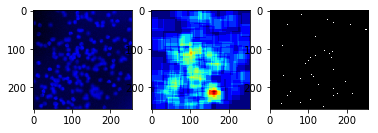

In [34]:
# plot 2 images to chcek that the labels are correct 
# DEBUG:
# image
plt.Figure(figsize=(5, 3), dpi=300)
plt.subplot(131)
img1 = np.array(np_dataset_x_train[1, ].reshape(input_shape), dtype=np.float32).astype(np.uint8)
plt.imshow(img1, cmap=plt.get_cmap('gray'))
# label
plt.subplot(132)
img2 = np.array(np_dataset_y_train[1, ].reshape(ext_shape), dtype=np.float32).astype(np.uint8)[:,:,0]
plt.imshow(img2[int(patch_size/2):-int(patch_size/2), int(patch_size/2):-int(patch_size/2)])
plt.subplot(133)
# img3 = np.array(np_dataset_l_train[0, ].reshape((320, 320)), dtype=np.float32).astype(np.uint8)
img3 = np_dataset_l_train[1, ].reshape((256, 256))
plt.imshow(img3, cmap=plt.get_cmap('gray'))
# print(img3[patch_size:-patch_size, patch_size:-patch_size])


print(np.sum(img3))



In [ ]:
# define data preparation
shift = 0.1
datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             # rotation_range=90,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'constant',
                             cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)
# fit parameters from data

print(np_dataset_x_train.shape, np_dataset_x_train.transpose((0, 2,3,1)).shape)

datagen.fit(np_dataset_x_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(np_dataset_x_train, np_dataset_y_train, batch_size=9):
    # , save_to_dir='images', save_prefix='aug', save_format='png'):
    print(X_batch.shape)  
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        img = np.array(X_batch[i].reshape(framesize, framesize, 3), dtype=np.float32).astype(np.uint8)
        print(img.shape)  
        plt.imshow(img, cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [35]:
np_dataset_l_train = np_dataset_l_train.transpose([0,2,3,1])
np_dataset_l_train.shape

(100, 256, 256, 1)

In [40]:
# in case of images and labels we have to use the following approach: 
# create 2 instances with the same arguments: 
shift = 0.02
image_data_gen_args = dict(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             # zca_whitening=True, 
                             rotation_range=5,
                             width_shift_range=shift, 
                             height_shift_range=shift,
                             fill_mode = 'wrap',
                             cval = 0,
                             horizontal_flip=True, 
                             vertical_flip=True)
datagen = ImageDataGenerator(**image_data_gen_args)
labelgen = ImageDataGenerator(**image_data_gen_args)


batch_size = 32

seed = args.seed
datagen.fit(np_dataset_x_train, augment=True, seed=seed)
# change this one to labels
labelgen.fit(np_dataset_l_train, augment=True, seed=seed)

image_generator = datagen.flow(
    np_dataset_x_train,
    seed=seed, 
    batch_size = batch_size,
    save_to_dir='data/aug', save_prefix='cell', save_format='png')
label_generator = labelgen.flow(
    np_dataset_l_train,
    seed=seed,
    batch_size = batch_size,
    save_to_dir='data/aug', save_prefix='dots', save_format='png')

# plt.rcParams['figure.figsize'] = (9, 5)

num_batches = 5
j_batch = 0
for X_batch, y_batch in zip(image_generator, label_generator):
    
    print(X_batch.shape, y_batch.shape) 
    
    j_batch += 1;
    # , save_to_dir='images', save_prefix='aug', save_format='png'): 
    # create a grid of 3x3 images
#     for i in range(0, 3):
#         plt.subplot(9, 2, 0 + 1 + 2*i) 
#         plt.figsize=(18, 9)
#         img = np.array(X_batch[i].reshape(framesize, framesize, 3), dtype=np.float32).astype(np.uint8)
#         plt.imshow(img, cmap=plt.get_cmap('gray'))

#         plt.subplot(9, 2, 0 + 1 + 2*i + 1) 
#         img = np.array(y_batch[i].reshape(framesize, framesize, 1), dtype=np.float32).astype(np.uint8)[:, :, 0]

#         print(img.shape)

#         plt.imshow(img, cmap=plt.get_cmap('gray'))          
    # show the plot
    plt.show()
    if (j_batch >= num_batches):
        break


# combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)
# model.fit_generator( train_generator, 
#     steps_per_epoch=2000,
#     epochs=50)

/home/milkyklim/anaconda/envs/python3/lib/python3.5/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (100, 256, 256, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


(32, 256, 256, 3) (32, 256, 256, 1)
(32, 256, 256, 3) (32, 256, 256, 1)
(32, 256, 256, 3) (32, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(32, 256, 256, 3) (32, 256, 256, 1)


In [ ]:
# examples of the images from the training set 
n_images_show = 7
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(image_generator[:n_images_show].astype(np.uint8),axis=1), interpolation='none');

In [ ]:
?image_generator